1. Самостоятельно разобраться с тем, что такое tfidf (документация https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html и еще - https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction)

Устанавливаем необходимые библиотеки

In [14]:
#!pip install razdel

In [15]:
#!pip install pymorphy2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 878.8 kB/s eta 0:00:00 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 8.3 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13707 sha256=0f1d9d5e5be22c05b0a26a12b8376658507323739b35d8fc592fc29c31909127
  Stored in directory: /Users/anastasia/Library/Caches/pip/wheels/7c/d7/8d/2156234738063e3d4a39ba77dc677046100e62766b53807189
Successfully built docopt


In [16]:
#!pip install pyLDAvis

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 7.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 4.8 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.0/24.0 MB 7.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 8.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 1.7 MB/s eta 0:00:00
  Attempting uninstall: joblib
    Found existing installation: joblib 1.1.1
    Uninstalling joblib-1.1.1:
      Successfully uninstalled joblib-1.1.1
  Attempting uninstall: pandas
    Found existing installation: pandas 1.5.3
    Uninstalling pandas-1.5.3:
      Successfully uninstalled pandas-1.5.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
woodwork 0.23.0 requires pandas<2.0.0,>=1.4.3, but you have pandas 2.0.3 which is incom

In [1]:
import pandas as pd

In [2]:
news = pd.read_csv("articles.csv")
print(news.shape)
news.head(3)

(27000, 2)


,doc_id,title
0,6,Заместитель председателяnправительства РФnСерг...
1,4896,Матч 1/16 финала Кубка России по футболу был п...
2,4897,Форвард «Авангарда» Томаш Заборский прокоммент...


Загрузим пользователей и списки последних прочитанных новостей

In [3]:
users = pd.read_csv("users_articles.csv")
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


Итак, нам нужно получить векторные представления пользователей на основе прочитанным ими новостей и самих новостей

### 1. Получаем векторные представления новостей

In [4]:
#from gensim.test.utils import common_texts
from gensim.corpora.dictionary import Dictionary

In [5]:
#предобработка текстов
import re
import numpy as np
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from razdel import tokenize # https://github.com/natasha/razdel

import pymorphy2

In [6]:
import nltk
nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

In [7]:
stopword_ru = stopwords.words('russian')
len(stopword_ru)

morph = pymorphy2.MorphAnalyzer()

In [8]:
len(stopword_ru)

151

In [9]:
with open('stopwords.txt') as f:
    additional_stopwords = [w.strip() for w in f.readlines() if w]
stopword_ru += additional_stopwords
len(stopword_ru)

776

In [10]:
def clean_text(text):
    '''
    очистка текста
    
    на выходе очищеный текст
    
    '''
    if not isinstance(text, str):
        text = str(text)
    
    text = text.lower()
    text = text.strip('\n').strip('\r').strip('\t')
    text = re.sub("-\s\r\n\|-\s\r\n|\r\n", '', str(text))

    text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
    text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n", ' ', text)
    text = re.sub(r'[\xad]|[\s+]', ' ', text.strip())
    #text = re.sub("n", ' ', text)
    
    #tokens = list(tokenize(text))
    #words = [_.text for _ in tokens]
    #words = [w for w in words if w not in stopword_ru]
    
    #return " ".join(words)
    return text

cache = {}

def lemmatization(text):
    '''
    лемматизация
        [0] если зашел тип не `str` делаем его `str`
        [1] токенизация предложения через razdel
        [2] проверка есть ли в начале слова '-'
        [3] проверка токена с одного символа
        [4] проверка есть ли данное слово в кэше
        [5] лемматизация слова
        [6] проверка на стоп-слова

    на выходе лист отлемматизированых токенов
    '''

    # [0]
    if not isinstance(text, str):
        text = str(text)
    
    # [1]
    tokens = list(tokenize(text))
    words = [_.text for _ in tokens]

    words_lem = []
    for w in words:
        if w[0] == '-': # [2]
            w = w[1:]
        if len(w)>1: # [3]
            if w in cache: # [4]
                words_lem.append(cache[w])
            else: # [5]
                temp_cach = cache[w] = morph.parse(w)[0].normal_form
                words_lem.append(temp_cach)
    
    words_lem_without_stopwords=[i for i in words_lem if not i in stopword_ru] # [6]
    
    return words_lem_without_stopwords

In [11]:
list(tokenize(news.iloc[0,1][:100]), )

[Substring(0, 11, 'Заместитель'),
 Substring(12, 24, 'председателя'),
 Substring(24, 25, 'n'),
 Substring(25, 38, 'правительства'),
 Substring(39, 41, 'РФ'),
 Substring(41, 42, 'n'),
 Substring(42, 48, 'Сергей'),
 Substring(48, 49, 'n'),
 Substring(49, 55, 'Иванов'),
 Substring(55, 56, 'n'),
 Substring(56, 62, 'избран'),
 Substring(63, 76, 'председателем'),
 Substring(77, 83, 'совета'),
 Substring(83, 84, 'n'),
 Substring(84, 87, 'ПБК'),
 Substring(88, 92, 'ЦСКА'),
 Substring(92, 93, 'n'),
 Substring(93, 94, '.'),
 Substring(95, 98, 'Как'),
 Substring(99, 100, 'с')]

In [15]:
%%time
#Запускаем очистку текста.
news['title'] = news['title'].apply(lambda x: clean_text(x), 1)

CPU times: user 11.7 s, sys: 130 ms, total: 11.8 s
Wall time: 11.8 s


In [16]:
%%time
#Запускаем лемматизацию текста.
news['title'] = news['title'].apply(lambda x: lemmatization(x), 1)

CPU times: user 1min 19s, sys: 152 ms, total: 1min 19s
Wall time: 1min 19s


А теперь в 3 строчки обучим нашу модель

In [17]:
#сформируем список наших текстов, разбив еще и на пробелы
texts = [t for t in news['title'].values]

# Create a corpus from a list of texts
common_dictionary = Dictionary(texts)
common_corpus = [common_dictionary.doc2bow(text) for text in texts]

Что такое common_dictionary и как он выглядит

In [18]:
common_dictionary[30]

'конституционный'

In [19]:
common_dictionary.id2token

{0: 'nn',
 1: 'александр',
 2: 'алексей',
 3: 'андрей',
 4: 'армеец',
 5: 'банк',
 6: 'баскетбол',
 7: 'близкий',
 8: 'блок',
 9: 'борьба',
 10: 'ватутин',
 11: 'взаимодействие',
 12: 'власть',
 13: 'войти',
 14: 'вячеслав',
 15: 'генералполковник',
 16: 'генеральный',
 17: 'георгий',
 18: 'гмк',
 19: 'директор',
 20: 'европа',
 21: 'единогласно',
 22: 'заместитель',
 23: 'заседание',
 24: 'защита',
 25: 'иванов',
 26: 'избрать',
 27: 'исакович',
 28: 'клиентский',
 29: 'клуб',
 30: 'конституционный',
 31: 'корпоративный',
 32: 'леонид',
 33: 'лопат',
 34: 'министр',
 35: 'мир',
 36: 'начальник',
 37: 'никель',
 38: 'новак',
 39: 'норильский',
 40: 'оао',
 41: 'обсуждение',
 42: 'округ',
 43: 'ольга',
 44: 'ооо',
 45: 'орган',
 46: 'основной',
 47: 'пбк',
 48: 'первый',
 49: 'перспектива',
 50: 'планирование',
 51: 'плешаков',
 52: 'политика',
 53: 'полномочный',
 54: 'полтавец',
 55: 'полтавченко',
 56: 'правительство',
 57: 'правление',
 58: 'председатель',
 59: 'прессслужба',
 60: '

Все просто - это словарь наших слов

Запускаем обучение

In [20]:
N_topic = 25  # можно менять

In [21]:
%%time
from gensim.models import LdaModel
# Обучаем модель на корпусе
lda = LdaModel(common_corpus, num_topics=N_topic, id2word=common_dictionary, passes=3)

CPU times: user 2min 37s, sys: 39.8 s, total: 3min 17s
Wall time: 34.1 s


In [22]:
from gensim.test.utils import datapath
# Сохраняем модель на диск
temp_file = datapath("model.lda")
lda.save(temp_file)

# Загружаем обученную модель с диска
lda = LdaModel.load(temp_file)

In [23]:
# Создаем новый корпус документов, которые раньше не видели
other_texts = [t for t in news['title'].iloc[:3]]
other_corpus = [common_dictionary.doc2bow(text) for text in other_texts]

unseen_doc = other_corpus[2]
print(other_texts[2])
lda[unseen_doc]

['форвард', 'авангард', 'томаш', 'заборский', 'прокомментировать', 'игра', 'команда', 'матч', 'чемпионат', 'кхл', 'против', 'атланта', 'nnnn', 'плохой', 'матч', 'нижний', 'новгород', 'против', 'торпедо', 'настраиваться', 'первый', 'минута', 'включиться', 'заборский', 'получиться', 'забросить', 'быстрый', 'гол', 'задать', 'хороший', 'темп', 'поединок', 'играть', 'хороший', 'сторона', 'пять', 'очко', 'выезд', 'девять', 'хороший']


[(8, 0.2047237),
 (13, 0.12847571),
 (17, 0.026760884),
 (19, 0.083342806),
 (20, 0.07077742),
 (21, 0.08314534),
 (22, 0.31578457),
 (23, 0.028577166),
 (24, 0.04195349)]

Обучили модель. Теперь 2 вопроса:

1. как выглядят наши темы
2. как получить для документа вектор значений (вероятности принадлежности каждой теме)

In [24]:
x = lda.show_topics(num_topics=N_topic, num_words=7, formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

# Печатаем только слова
for topic, words in topics_words:
    print(f"topic_{topic}: " + " ".join(words))

topic_0: сша украина украинский россия американский российский санкция
topic_1: проект банк новый средство обнаружить развитие технология
topic_2: рубль млн рынок рост тыс составить доход
topic_3: кризис польша дождь лёд фрагмент польский су
topic_4: nn день москва мероприятие участник сайт участие
topic_5: газ земля век северный проект солнце риск
topic_6: ракета армия погибнуть первый советский новый писать
topic_7: сотрудник статья орган уголовный убийство власть задержать
topic_8: всё млрд большой первый цена очень эксперт
topic_9: nn ребёнок исследование научный женщина жизнь мужчина
topic_10: россия российский путин nn глава государство владимир
topic_11: произойти пострадать аэропорт инцидент причина авария район
topic_12: препарат обращение университет nthe доллар необычный исследование
topic_13: пациент турция болезнь операция турецкий миссия лечение
topic_14: иран израиль употребление израильский высота медведь сектор
topic_15: великобритания британский место рейтинг германия

Очень неплохо - большинство тем вполне можно описать о чем они

Давайте напишем функцию, которая будет нам возвращать векторное представление новости

In [25]:
#text = news['title'].iloc[0]

def get_lda_vector(lda, text):
    unseen_doc = common_dictionary.doc2bow(text)
    lda_tuple = lda[unseen_doc]

    not_null_topics = dict(zip([i[0] for i in lda_tuple], [i[1] for i in lda_tuple]))

    output_vector = []
    for i in range(N_topic):
        if i not in not_null_topics:
            output_vector.append(0)
        else:
            output_vector.append(not_null_topics[i])
    return np.array(output_vector)

In [26]:
get_lda_vector(lda, news['title'].iloc[0])

array([0.        , 0.14830494, 0.        , 0.        , 0.09373602,
       0.        , 0.011262  , 0.        , 0.08131032, 0.        ,
       0.        , 0.        , 0.        , 0.02738098, 0.        ,
       0.        , 0.06324668, 0.        , 0.        , 0.        ,
       0.50737631, 0.        , 0.06089547, 0.        , 0.        ])

In [27]:
topic_matrix = pd.DataFrame([get_lda_vector(lda, text) for text in news['title'].values])
topic_matrix.columns = [f'topic_{i}' for i in range(N_topic)]
topic_matrix['doc_id'] = news['doc_id'].values
topic_matrix = topic_matrix[['doc_id']+[f'topic_{i}' for i in range(N_topic)]]
topic_matrix.head(5)

,doc_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,6,0.0,0.148295,0.0,0.0,0.093734,0.0,0.011262,0.000000,0.081306,...,0.0,0.063265,0.000000,0.0,0.000000,0.507374,0.000000,0.060895,0.000000,0.000000
1,4896,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.159116,0.000000,...,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.264934,0.000000,0.000000
2,4897,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.204786,...,0.0,0.000000,0.026761,0.0,0.083352,0.070777,0.083052,0.315759,0.028575,0.041959
3,4898,0.0,0.000000,0.0,0.0,0.087334,0.0,0.000000,0.000000,0.729380,...,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.017713,0.154920,0.000000,0.000000
4,4899,0.0,0.043545,0.0,0.0,0.202737,0.0,0.000000,0.000000,0.000000,...,0.0,0.471582,0.000000,0.0,0.000000,0.150953,0.000000,0.000000,0.000000,0.000000


Прекрасно, мы получили вектора наших новостей! И даже умеем интерпретировать получившиеся темы.

Можно двигаться далее

### Следующий шаг - векторные представления пользователей

In [28]:
users.head(5)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"
3,u101138,"[5933, 6186, 5055, 6977, 5206, 488389]"
4,u108248,"[707, 1144, 2532, 2928, 3133, 324592]"


In [29]:
doc_dict = dict(zip(topic_matrix['doc_id'].values, topic_matrix[[f'topic_{i}' for i in range(N_topic)]].values))

In [30]:
doc_dict[293622]

array([0.        , 0.        , 0.        , 0.        , 0.22717205,
       0.        , 0.14138146, 0.        , 0.        , 0.25835937,
       0.19800818, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.01845162, 0.        , 0.04566363,
       0.        , 0.        , 0.        , 0.02946019, 0.06996375])

In [31]:
def get_user_embedding(user_articles_list, doc_dict, func):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = func(user_vector, axis=0)
    return user_vector

In [32]:
user_articles_list = users['articles'].iloc[33]

get_user_embedding(user_articles_list, doc_dict, np.mean)

array([0.062161  , 0.02232132, 0.01854077, 0.        , 0.01883516,
       0.02379716, 0.02142346, 0.08904518, 0.11260245, 0.03417254,
       0.26938802, 0.00555941, 0.        , 0.        , 0.        ,
       0.02411616, 0.04313304, 0.00289033, 0.01070212, 0.04766913,
       0.04482463, 0.12769058, 0.        , 0.00845419, 0.        ])

Теперь получим эмбединги для всех пользователей и проверим их качество на конкретной downstream-задаче

In [33]:
stat = np.mean

In [34]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x, doc_dict, stat))])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(N_topic)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(N_topic)]]
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.041063,0.041215,0.021158,0.000000,0.171400,0.000000,0.106980,0.095826,0.036744,...,0.000000,0.019466,0.012158,0.000000,0.007611,0.023368,0.013562,0.000000,0.014078,0.016459
1,u108690,0.097476,0.008962,0.033535,0.001782,0.020823,0.004140,0.005594,0.081979,0.189117,...,0.000000,0.037852,0.000000,0.000000,0.004852,0.040180,0.083859,0.004975,0.002195,0.006018
2,u108339,0.027804,0.017298,0.024100,0.001874,0.102398,0.025164,0.062132,0.105529,0.051463,...,0.033361,0.035456,0.002542,0.006503,0.004684,0.053832,0.082342,0.000000,0.011662,0.000000


Датасет готов - можно попробовать обучить модель. Загрузим нашу разметку

In [35]:
target = pd.read_csv("users_churn.csv")
target.head(3)

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0


In [36]:
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.041063,0.041215,0.021158,0.000000,0.171400,0.000000,0.106980,0.095826,0.036744,...,0.019466,0.012158,0.000000,0.007611,0.023368,0.013562,0.000000,0.014078,0.016459,0
1,u108690,0.097476,0.008962,0.033535,0.001782,0.020823,0.004140,0.005594,0.081979,0.189117,...,0.037852,0.000000,0.000000,0.004852,0.040180,0.083859,0.004975,0.002195,0.006018,1
2,u108339,0.027804,0.017298,0.024100,0.001874,0.102398,0.025164,0.062132,0.105529,0.051463,...,0.035456,0.002542,0.006503,0.004684,0.053832,0.082342,0.000000,0.011662,0.000000,1


In [37]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
#import itertools

import matplotlib.pyplot as plt

%matplotlib inline

In [38]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(N_topic)]], 
                                                    X['churn'], random_state=0, test_size=0.25)

In [39]:
logreg = LogisticRegression()
#обучим 
logreg.fit(X_train, y_train)

LogisticRegression()

In [40]:
#наши прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([0.07975826, 0.10516982, 0.48127246, 0.23539499, 0.07953322,
       0.07068998, 0.09499176, 0.03826726, 0.11342256, 0.11281778])

In [41]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

### Рассчитаем Precision, Recall, F_score

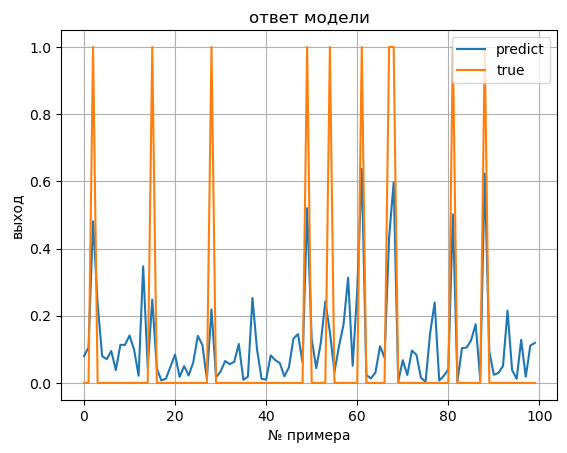

In [42]:
plt.plot( preds[:100], label = 'predict')
plt.plot(y_test.values[:100], label = 'true')
plt.title('ответ модели')
plt.xlabel('№ примера')
plt.ylabel('выход')
plt.legend()
plt.grid('On')
plt.show()

In [43]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print(f'Best Threshold={thresholds[ix]}, F-Score={fscore[ix]:.3f}, Precision={precision[ix]:.3f}, Recall={recall[ix]:.3f}')                                                                        

Best Threshold=0.28643319069465195, F-Score=0.773, Precision=0.788, Recall=0.759


In [44]:
import itertools

In [45]:
roc_auc = roc_auc_score(y_test, preds)
roc_auc

0.9700959358102215

В целом мы видим, что получившиеся векторные представления содержат какой-то сигнал и позволяют решать нашу прикладную задачу. 

In [46]:
metrics = pd.DataFrame(columns=['stat', 'thresh', 'F-Score', 'Precision', 'Recall', 'ROC AUC'])
metrics

,stat,thresh,F-Score,Precision,Recall,ROC AUC


In [48]:
new_row_1 = {
    'stat': stat.__name__,
    'thresh': thresholds[ix],
    'F-Score': fscore[ix],
    'Precision': precision[ix],
    'Recall': recall[ix],
    'ROC AUC': roc_auc
}

temp_df_1 = pd.DataFrame(new_row_1, index=[0])

In [49]:
# Объединение временного DataFrame с основным DataFrame
metrics = pd.concat([metrics, temp_df_1], ignore_index=True)
metrics

,stat,thresh,F-Score,Precision,Recall,ROC AUC
0,mean,0.286433,0.773389,0.788136,0.759184,0.970096


2. Модифицировать код функции get_user_embedding таким образом, чтобы считалось не среднее (как в примере np.mean), а медиана. Применить такое преобразование к данным, обучить модель прогнозирования оттока и посчитать метрики качества и сохранить их: roc auc, precision/recall/f_score (для 3 последних - подобрать оптимальный порог с помощью precision_recall_curve, как это делалось на уроке)

In [50]:
stat = np.median

In [51]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x, doc_dict, stat))])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(N_topic)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(N_topic)]]
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.000000,0.0,0.000000,0.0,0.178961,0.000000,0.102670,0.098307,0.000000,...,0.0,0.000000,0.006001,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
1,u108690,0.123376,0.0,0.000000,0.0,0.007513,0.000000,0.000000,0.052992,0.178262,...,0.0,0.030397,0.000000,0.0,0.0,0.020657,0.088841,0.0,0.0,0.0
2,u108339,0.000000,0.0,0.011213,0.0,0.069116,0.014668,0.021556,0.107620,0.042195,...,0.0,0.032238,0.000000,0.0,0.0,0.060078,0.058416,0.0,0.0,0.0


In [52]:
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.000000,0.0,0.000000,0.0,0.178961,0.000000,0.102670,0.098307,0.000000,...,0.000000,0.006001,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0
1,u108690,0.123376,0.0,0.000000,0.0,0.007513,0.000000,0.000000,0.052992,0.178262,...,0.030397,0.000000,0.0,0.0,0.020657,0.088841,0.0,0.0,0.0,1
2,u108339,0.000000,0.0,0.011213,0.0,0.069116,0.014668,0.021556,0.107620,0.042195,...,0.032238,0.000000,0.0,0.0,0.060078,0.058416,0.0,0.0,0.0,1


In [53]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(N_topic)]], 
                                                    X['churn'], random_state=0, test_size=0.25)

In [54]:
logreg = LogisticRegression()
#обучим 
logreg.fit(X_train, y_train)

LogisticRegression()

In [55]:
#наши прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([0.14187753, 0.02566948, 0.37329445, 0.19670718, 0.00962244,
       0.05228684, 0.07304639, 0.02473178, 0.0957351 , 0.08048717])

__Рассчитаем Precision, Recall, F_score для np.median__

In [56]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print(f'Best Threshold={thresholds[ix]}, F-Score={fscore[ix]:.3f}, Precision={precision[ix]:.3f}, Recall={recall[ix]:.3f}')                                                                        

Best Threshold=0.3165558307374936, F-Score=0.751, Precision=0.792, Recall=0.714


In [57]:
roc_auc = roc_auc_score(y_test, preds)
roc_auc

0.9672632129774987

In [58]:
new_row_2 = {
    'stat': stat.__name__,
    'thresh': thresholds[ix],
    'F-Score': fscore[ix],
    'Precision': precision[ix],
    'Recall': recall[ix],
    'ROC AUC': roc_auc
}

temp_df_2 = pd.DataFrame(new_row_2, index=[0])

In [59]:
# Объединение временного DataFrame с основным DataFrame
metrics = pd.concat([metrics, temp_df_2], ignore_index=True)
metrics

,stat,thresh,F-Score,Precision,Recall,ROC AUC
0,mean,0.286433,0.773389,0.788136,0.759184,0.970096
1,median,0.316556,0.751073,0.791855,0.714286,0.967263


3. Повторить п.2, но используя уже не медиану, а max

In [60]:
stat = np.max

In [61]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x, doc_dict, stat))])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(N_topic)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(N_topic)]]
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.184117,0.247288,0.074912,0.000000,0.432110,0.000000,0.228567,0.191774,0.160146,...,0.000000,0.081765,0.042493,0.000000,0.045664,0.082932,0.081373,0.000000,0.055008,0.069964
1,u108690,0.169221,0.043385,0.108405,0.010689,0.085439,0.024841,0.033565,0.267090,0.357494,...,0.000000,0.104494,0.000000,0.000000,0.029114,0.126992,0.136078,0.029853,0.013169,0.036107
2,u108339,0.147947,0.070291,0.070198,0.011245,0.341735,0.078620,0.174990,0.200505,0.118612,...,0.158987,0.072549,0.015249,0.039021,0.016780,0.121404,0.253933,0.000000,0.069970,0.000000


In [62]:
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.184117,0.247288,0.074912,0.000000,0.432110,0.000000,0.228567,0.191774,0.160146,...,0.081765,0.042493,0.000000,0.045664,0.082932,0.081373,0.000000,0.055008,0.069964,0
1,u108690,0.169221,0.043385,0.108405,0.010689,0.085439,0.024841,0.033565,0.267090,0.357494,...,0.104494,0.000000,0.000000,0.029114,0.126992,0.136078,0.029853,0.013169,0.036107,1
2,u108339,0.147947,0.070291,0.070198,0.011245,0.341735,0.078620,0.174990,0.200505,0.118612,...,0.072549,0.015249,0.039021,0.016780,0.121404,0.253933,0.000000,0.069970,0.000000,1


In [63]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(N_topic)]], 
                                                    X['churn'], random_state=0, test_size=0.25)

In [64]:
logreg = LogisticRegression()
#обучим 
logreg.fit(X_train, y_train)

LogisticRegression()

In [65]:
#наши прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([0.07099995, 0.09219265, 0.85014517, 0.24955583, 0.05862029,
       0.02744205, 0.04162115, 0.04910832, 0.01033774, 0.10155093])

__Рассчитаем Precision, Recall, F_score для np.median__

In [66]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print(f'Best Threshold={thresholds[ix]}, F-Score={fscore[ix]:.3f}, Precision={precision[ix]:.3f}, Recall={recall[ix]:.3f}')                                                                        

Best Threshold=0.3235127559996767, F-Score=0.855, Precision=0.842, Recall=0.869


In [67]:
roc_auc = roc_auc_score(y_test, preds)
roc_auc

0.9845456131170416

In [68]:
new_row_3 = {
    'stat': stat.__name__,
    'thresh': thresholds[ix],
    'F-Score': fscore[ix],
    'Precision': precision[ix],
    'Recall': recall[ix],
    'ROC AUC': roc_auc
}

temp_df_3 = pd.DataFrame(new_row_3, index=[0])

In [69]:
# Объединение временного DataFrame с основным DataFrame
metrics = pd.concat([metrics, temp_df_3], ignore_index=True)
metrics

,stat,thresh,F-Score,Precision,Recall,ROC AUC
0,mean,0.286433,0.773389,0.788136,0.759184,0.970096
1,median,0.316556,0.751073,0.791855,0.714286,0.967263
2,amax,0.323513,0.855422,0.841897,0.869388,0.984546


4. (опциональное, если очень хочется) Воспользовавшись полученными знаниями из п.1, повторить пункт 2, но уже взвешивая новости по tfidf (подсказка: нужно получить веса-коэффициенты для каждого документа. Не все документы одинаково информативны и несут какой-то положительный сигнал). Подсказка 2 - нужен именно idf, как вес.

In [70]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [71]:
users['articles_str'] = users['articles'].apply(lambda x: x.replace('[','').replace(']', '').replace(',', ''))
users['articles_str'].iloc[0]

'293672 293328 293001 293622 293126 1852'

In [72]:
tfidf = TfidfVectorizer()
tfidf.fit(users['articles_str'])

TfidfVectorizer()

In [73]:
idf = pd.DataFrame({'article_id': tfidf.get_feature_names_out(),
                    'idf': tfidf.idf_})
idf

,article_id,idf
0,10,8.888710
1,100,7.907880
2,1000,8.041412
3,1001,8.888710
4,1002,8.888710
...,...,...
14776,995,8.377884
14777,996,8.195562
14778,997,8.601027
14779,998,9.294175


In [74]:
def get_user_embedding_idf(user_articles_list, doc_dict):
    user_articles_list = eval(user_articles_list)
    
    user_vector = np.zeros((len(user_articles_list), N_topic))
    for i, doc_id in enumerate(user_articles_list):
        try:
            weight = idf[idf['article_id'] == str(doc_id)]['idf'].values[0]
        except Exception as e:
            weight = 0
        user_vector[i] = doc_dict[doc_id] * weight

    user_vector = np.median(user_vector, axis=0)
    return user_vector

In [75]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding_idf(x, doc_dict))])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(N_topic)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(N_topic)]]
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.000000,0.0,0.000000,0.0,1.560811,0.000000,0.883066,0.845543,0.000000,...,0.0,0.000000,0.051616,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
1,u108690,1.096655,0.0,0.000000,0.0,0.066781,0.000000,0.000000,0.471028,1.507041,...,0.0,0.278461,0.000000,0.0,0.0,0.181461,0.768471,0.0,0.0,0.0
2,u108339,0.000000,0.0,0.091894,0.0,0.588003,0.120212,0.180598,0.865433,0.350778,...,0.0,0.290211,0.000000,0.0,0.0,0.528681,0.483746,0.0,0.0,0.0


In [76]:
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.000000,0.0,0.000000,0.0,1.560811,0.000000,0.883066,0.845543,0.000000,...,0.000000,0.051616,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0
1,u108690,1.096655,0.0,0.000000,0.0,0.066781,0.000000,0.000000,0.471028,1.507041,...,0.278461,0.000000,0.0,0.0,0.181461,0.768471,0.0,0.0,0.0,1
2,u108339,0.000000,0.0,0.091894,0.0,0.588003,0.120212,0.180598,0.865433,0.350778,...,0.290211,0.000000,0.0,0.0,0.528681,0.483746,0.0,0.0,0.0,1


In [77]:
# разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X[[f'topic_{i}' for i in range(N_topic)]], 
                                                    X['churn'], random_state=0, test_size=0.25)

In [78]:
logreg = LogisticRegression()
#обучим 
logreg.fit(X_train, y_train)

LogisticRegression()

In [79]:
#наши прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([1.83551302e-01, 1.66820756e-04, 3.69175206e-01, 3.22210766e-02,
       1.86614224e-05, 1.80922804e-03, 2.68530735e-03, 1.05236906e-05,
       2.55251951e-03, 5.31965515e-03])

__Рассчитаем Precision, Recall, F_score для np.median__

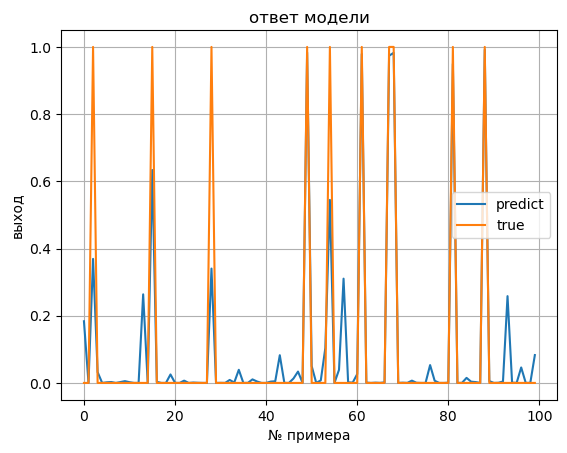

In [84]:
plt.plot( preds[:100], label = 'predict')
plt.plot(y_test.values[:100], label = 'true')
plt.title('ответ модели')
plt.xlabel('№ примера')
plt.ylabel('выход')
plt.legend()
plt.grid('On')
plt.show()

In [80]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print(f'Best Threshold={thresholds[ix]}, F-Score={fscore[ix]:.3f}, Precision={precision[ix]:.3f}, Recall={recall[ix]:.3f}')                                                                        

Best Threshold=0.3691752063471417, F-Score=0.859, Precision=0.858, Recall=0.861


In [81]:
roc_auc = roc_auc_score(y_test, preds)
roc_auc

0.98572940287226

In [82]:
new_row_4 = {
    'stat': 'idf_median',
    'thresh': thresholds[ix],
    'F-Score': fscore[ix],
    'Precision': precision[ix],
    'Recall': recall[ix],
    'ROC AUC': roc_auc
}

temp_df_4 = pd.DataFrame(new_row_4, index=[0])

5. Сформировать на выходе единую таблицу, сравнивающую качество 3 разных метода получения эмбедингов пользователей: mean, median, max, idf_mean по метрикам roc_auc, precision, recall, f_score

In [83]:
# Объединение временного DataFrame с основным DataFrame
metrics = pd.concat([metrics, temp_df_4], ignore_index=True)
metrics

,stat,thresh,F-Score,Precision,Recall,ROC AUC
0,mean,0.286433,0.773389,0.788136,0.759184,0.970096
1,median,0.316556,0.751073,0.791855,0.714286,0.967263
2,amax,0.323513,0.855422,0.841897,0.869388,0.984546
3,idf_median,0.369175,0.859470,0.857724,0.861224,0.985729
